In [1]:
from __future__ import division, print_function

# Python imports
import numpy as np # Matrix and vector computation package
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
from matplotlib import cm  # Colormaps
from matplotlib.colors import LogNorm  # Log colormaps
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator so that the tutorial is reproducable
#np.random.seed(seed=1)

In [2]:
# Define plotting functions

# Define points to annotate (wx, wRec, color)
points = [(2,1,'r'), (1,2,'b'), (1,-2,'g'), (1,0,'c'), (1,0.5,'m'), (1,-0.5,'y')]

def get_cost_surface(w1_low, w1_high, w2_low, w2_high, nb_of_ws, cost_func):
    """Define a vector of weights for which we want to plot the cost."""
    w1 = np.linspace(w1_low, w1_high, num=nb_of_ws)  # Weight 1
    w2 = np.linspace(w2_low, w2_high, num=nb_of_ws)  # Weight 2
    ws1, ws2 = np.meshgrid(w1, w2)  # Generate grid
    cost_ws = np.zeros((nb_of_ws, nb_of_ws))  # Initialize cost matrix
    # Fill the cost matrix for each combination of weights
    for i in range(nb_of_ws):
        for j in range(nb_of_ws):
            cost_ws[i,j] = cost_func(ws1[i,j], ws2[i,j])
    return ws1, ws2, cost_ws

def plot_surface(ax, ws1, ws2, cost_ws):
    """Plot the cost in function of the weights."""
    surf = ax.contourf(ws1, ws2, cost_ws, levels=np.logspace(-0.2, 8, 30), cmap=cm.pink, norm=LogNorm())
    ax.set_xlabel('$w_{in}$', fontsize=15)
    ax.set_ylabel('$w_{rec}$', fontsize=15)
    return surf

def plot_points(ax, points):
    """Plot the annotation points on the given axis."""
    for wx, wRec, c in points:
        ax.plot(wx, wRec, c+'o', linewidth=2)

def get_cost_surface_figure(cost_func, points):
    """Plot the cost surfaces together with the annotated points."""
    # Plot figures
    fig = plt.figure(figsize=(10, 4))
    # Plot overview of cost function
    ax_1 = fig.add_subplot(1,2,1)
    ws1_1, ws2_1, cost_ws_1 = get_cost_surface(-3, 3, -3, 3, 100, cost_func)
    surf_1 = plot_surface(ax_1, ws1_1, ws2_1, cost_ws_1 + 1)
    plot_points(ax_1, points)
    ax_1.set_xlim(-3, 3)
    ax_1.set_ylim(-3, 3)
    # Plot zoom of cost function
    ax_2 = fig.add_subplot(1,2,2)
    ws1_2, ws2_2, cost_ws_2 = get_cost_surface(0, 2, 0, 2, 100, cost_func)
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, cost_ws_2 + 1)
    plot_points(ax_2, points)
    ax_2.set_xlim(0, 2)
    ax_2.set_ylim(0, 2)
    # Show the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.12, 0.03, 0.78])
    cbar = fig.colorbar(surf_1, ticks=np.logspace(0, 8, 9), cax=cax)
    cbar.ax.set_ylabel('$\\xi$', fontsize=15, rotation=0, labelpad=20)
    cbar.set_ticklabels(['{:.0e}'.format(i) for i in np.logspace(0, 8, 9)])
    fig.suptitle('Cost surface', fontsize=15)
    return fig

def plot_gradient_over_time(points, get_grad_over_time):
    """Plot the gradients of the annotated point and how the evolve over time."""
    fig = plt.figure(figsize=(6.5, 4))
    ax = plt.subplot(111)
    # Plot points
    for wx, wRec, c in points:
        grad_over_time = get_grad_over_time(wx, wRec)
        x = np.arange(-grad_over_time.shape[1]+1, 1, 1)
        plt.plot(x, np.sum(grad_over_time, axis=0), c+'-', label='({0}, {1})'.format(wx, wRec), linewidth=1, markersize=8)
    plt.xlim(0, -grad_over_time.shape[1]+1)
    # Set up plot axis
    plt.xticks(x)
    plt.yscale('symlog')
    plt.yticks([10**8, 10**6, 10**4, 10**2, 0, -10**2, -10**4, -10**6, -10**8])
    plt.xlabel('timestep k', fontsize=12)
    plt.ylabel('$\\frac{\\partial \\xi}{\\partial S_{k}}$', fontsize=20, rotation=0)
    plt.grid()
    plt.title('Unstability of gradient in backward propagation.\n(backpropagate from left to right)')
    # Set legend
    leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, numpoints=1)
    leg.set_title('$(w_x, w_{rec})$', prop={'size':15})

def get_grad_over_time(wx, wRec):
    """Helper func to only get the gradient over time from wx and wRec."""
    S = forward(X, wx, wRec)
    _, grad_over_time = backward(X, S, t, wx, wRec)
    return grad_over_time

In [3]:
# Create dataset
nb_of_samples = 100
sequence_len = 10
# Create the sequences
X = np.zeros((nb_of_samples, sequence_len))
t = np.zeros((nb_of_samples))
for row_idx in range(nb_of_samples):
    X[row_idx,:] = np.around(np.random.rand(sequence_len)).astype(int)
    t[row_idx] = np.sum(X[row_idx,:]) % 2
# Create the targets for each sequence

print('X: ', X[0,:])
print('t: ', t[0])

X:  [ 1.  0.  0.  0.  1.  1.  0.  1.  0.  0.]
t:  0.0


In [4]:
def forward(X, U, W):
    """
    Unfold the network and compute all state activations given the input X,
    and input weights (wx) and recursive weights (wRec).
    Return the state activations in a matrix, the last column S[:,-1] contains the
    final activations.
    """
    # Initialise the matrix that holds all states for all input sequences.
    # The initial state s0 is set to 0.
    S = np.zeros((nb_of_samples, sequence_len+1))
    # Update the states over the sequence
    for k in range(0, sequence_len):
        S[:,k+1] = X[:,k] * -1 + S[:,k] * W
    Y = 1.0 / (1 + np.exp(-(S[:,-1] * U)))
    return S, Y

def cost(Y, T):
    """
    Return the MSE between the targets t and the outputs y.
    """
    return - np.sum(np.multiply(T, np.log(Y+1e-99)) + np.multiply((1-T), np.log(1-Y+1e-99)))

def backward(X, S, Y, T, U, W):
    """
    Backpropagate the gradient computed at the output (grad_out) through the network.
    Accumulate the parameter gradients for wX and wRec by for each layer by addition.
    Return the parameter gradients as a tuple, and the gradients at the output of each layer.
    """
    #print('Y: ', Y.shape)
    #print('T: ', T.shape)
    grad_out = Y - T
    #print('grad_out: ', grad_out.shape)
    # Initialise the array that stores the gradients of the cost with respect to the states.
    grad_over_time = np.zeros((X.shape[0], X.shape[1]+1))
    #print('grad_over_time: ', grad_over_time.shape)
    grad_over_time[:,-1] = grad_out * U
    #print('S[:,-1]: ', S[:,-1])
    #print('grad_out: ', grad_out)
    gU = np.sum(S[:,-1] * grad_out)
    #print('gU: ', gU)
    # Set the gradient accumulations to 0
    gW = 0
    for k in range(X.shape[1], 0, -1):
        # Compute the parameter gradients and accumulate the results.
        #gU += np.sum(grad_over_time[:,k] * X[:,k-1])
        gW += np.sum(grad_over_time[:,k] * S[:,k-1])
        # Compute the gradient at the output of the previous layer
        grad_over_time[:,k-1] = grad_over_time[:,k] * W
    return (gU, gW), grad_over_time

In [5]:
# Perform gradient checking
# Set the weight parameters used during gradient checking
params = [0.1, 0.1]  # [U, W]
# Set the small change to compute the numerical gradient
eps = 1e-7
# Compute the backprop gradients
S, Y = forward(X, params[0], params[1])
backprop_grads, grad_over_time = backward(X, S, Y, t, params[0], params[1])
# Compute the numerical gradient for each parameter in the layer
for p_idx, _ in enumerate(params):
    grad_backprop = backprop_grads[p_idx]
    # + eps
    params[p_idx] += eps
    plus_cost = cost(forward(X, params[0], params[1])[1], t)
    # - eps
    params[p_idx] -= 2 * eps
    min_cost = cost(forward(X, params[0], params[1])[1], t)
    # reset param value
    params[p_idx] += eps
    # calculate numerical gradient
    grad_num = (plus_cost - min_cost) / (2*eps)
    print('p: ', p_idx, params[p_idx], backprop_grads[p_idx], grad_num)
    # Raise error if the numerical grade is not close to the backprop gradient
    if not np.isclose(grad_num, grad_backprop):
        raise ValueError('Numerical gradient of {:.6f} is not close to the backpropagation gradient of {:.6f}!'.format(float(grad_num), float(grad_backprop)))
print('No gradient errors found')

p:  0 0.1 1.39203845608 1.39203848448
p:  1 0.1 0.538167180124 0.538167199693
No gradient errors found


In [6]:
# # Perform gradient descent
# 
# # Set hyperparameters
# lr = 0.0003
# 
# # Set initial parameters
# params = [1, -1]  # [U, W]
# 
# ls_of_ws = [(params[0], params[1])]  # List of weights to plot
# ls_of_costs = [cost(forward(X, params[0], params[1])[1], t)]
# ls_of_gW = []
# # Iterate over 500 iterations
# for i in range(2000):
#     # Perform forward and backward pass to get the gradients
#     S, Y = forward(X, params[0], params[1])
#     gparams, _ = backward(X, S, Y, t, params[1])
#     ls_of_gW.append(gparams[1])
#     # Get the update values and sign of the last gradient
#     params = [(p - gp * lr) for p, gp in zip(params, gparams)]
#     c = cost(forward(X, params[0], params[1])[1], t)
#     ls_of_costs.append(c)
#     ls_of_ws.append((params[0], params[1]))  # Add weights to list to plot
# 
# print('Final weights are: wx = {0},  wRec = {1}'.format(params[0], params[1]))

In [7]:
# Perform Rprop optimisation

# Set hyperparameters
eta_p = 1.2
eta_n = 0.5

# Set initial parameters
params = [-1, 1]  # [U, W]
params_delta = [0.001, 0.001]  # Update values (Delta) for W
params_sign = [0, 0]  # Previous sign of W

ls_of_ws = [(params[0], params[1])]  # List of weights to plot
ls_of_costs = [cost(forward(X, params[0], params[1])[1], t)]
ls_of_gW = []
# Iterate over 500 iterations
for i in range(500):
    # Perform forward and backward pass to get the gradients
    S, Y = forward(X, params[0], params[1])
    gparams, _ = backward(X, S, Y, t, params[0], params[1])
    ls_of_gW.append(gparams[1])
    params_sign_new = np.sign(gparams)  # Sign of new gradient
    # Get the update values and sign of the last gradient
    # Update the Delta (update value) for each weight parameter seperately
    params_delta = [
        (pd * eta_p) if psn == ps else (pd * eta_n)
        for pd, psn, ps in zip(params_delta, params_sign_new, params_sign)]
    params_sign = params_sign_new
    # Update each weight parameter seperately
    for i, _ in enumerate(params):
        params[i] -= params_sign[i] * params_delta[i]
    c = cost(forward(X, params[0], params[1])[1], t)
    ls_of_costs.append(c)
    ls_of_ws.append((params[0], params[1]))  # Add weights to list to plot

print('Final weights are: wx = {0},  wRec = {1}'.format(params[0], params[1]))

Final weights are: wx = -0.055555642777,  wRec = 0.702734617072


In [8]:
sample_idx = 3
S, Y = forward(X, params[0], params[1])
print('X: ', X[sample_idx,:])
print('t: ', t[sample_idx])
print('Y: ', Y[sample_idx])



X:  [ 1.  0.  1.  0.  1.  0.  0.  1.  0.  1.]
t:  1.0
Y:  0.524863436066


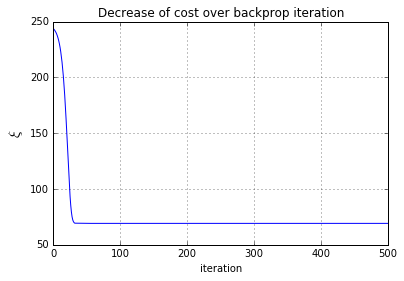

In [9]:
# Plot the cost over the iterations
plt.plot(ls_of_costs, 'b-')
plt.xlabel('iteration')
plt.ylabel('$\\xi$', fontsize=15)
plt.title('Decrease of cost over backprop iteration')
plt.grid()
plt.show()

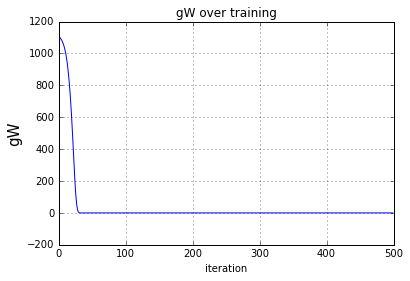

In [10]:
plt.plot(ls_of_gW, 'b-')
plt.xlabel('iteration')
plt.ylabel('gW', fontsize=15)
plt.title('gW over training')
plt.grid()
plt.show()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: overflow encountered in exp


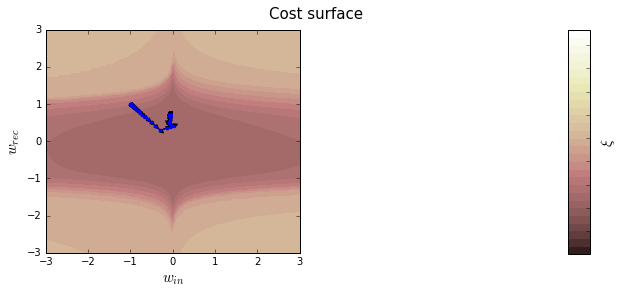

In [11]:
# Plot the cost surface with the weights over the iterations.

# Define plot function
def plot_optimisation(ls_of_ws, cost_func):
    """Plot the optimisation iterations on the cost surface."""
    ws1, ws2 = zip(*ls_of_ws)
    # Plot figures
    fig = plt.figure(figsize=(10, 4))
    # Plot overview of cost function
    ax_1 = fig.add_subplot(1,2,1)
    ws1_1, ws2_1, cost_ws_1 = get_cost_surface(-3, 3, -3, 3, 100, cost_func)
    surf_1 = plot_surface(ax_1, ws1_1, ws2_1, cost_ws_1 + 1)
    for i in xrange(1, len(ws1)):
        ax_1.arrow(ws1[i-1], ws2[i-1], ws1[i]-ws1[i-1], ws2[i]-ws2[i-1], 
                   head_width=0.1, head_length=0.1, fc='k', ec='k')
    ax_1.plot(ws1, ws2, 'b.-')
    ax_1.set_xlim([-3,3])
    ax_1.set_ylim([-3,3])
    # Plot zoom of cost function
    #ax_2 = fig.add_subplot(1,2,2)
    #ws1_2, ws2_2, cost_ws_2 = get_cost_surface(0, 2, 0, 2, 100, cost_func)
    #surf_2 = plot_surface(ax_2, ws1_2, ws2_2, cost_ws_2 + 1)
    #ax_2.set_xlim([0,2])
    #ax_2.set_ylim([0,2])
    #surf_2 = plot_surface(ax_2, ws1_2, ws2_2, cost_ws_2)
    #for i in xrange(1, len(ws1)):
    #    ax_2.arrow(ws1[i-1], ws2[i-1], ws1[i]-ws1[i-1], ws2[i]-ws2[i-1], 
    #           head_width=0.05, head_length=0.05, fc='k', ec='k')
    #ax_2.plot(ws1, ws2, 'b.-')
    ## Show the colorbar
    #fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.12, 0.03, 0.78])
    #cbar = fig.colorbar(surf_1, ticks=np.logspace(0, 8, 9), cax=cax)
    cbar = fig.colorbar(surf_1, cax=cax)
    cbar.ax.set_ylabel('$\\xi$', fontsize=15)
    #cbar.set_ticklabels(['{:.0e}'.format(i) for i in np.logspace(0, 8, 9)])
    plt.suptitle('Cost surface', fontsize=15)
    plt.show()

# Plot the optimisation
plot_optimisation(ls_of_ws, lambda w1, w2: cost(forward(X, w1, w2)[1] , t))
plt.show()